In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
 94% 1.00G/1.06G [00:22<00:05, 12.8MB/s]
100% 1.06G/1.06G [00:22<00:00, 51.2MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
train_dir = "/content/train"
test_dir = "/content/test"

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
    directory=train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(256, 256),
    batch_size=32,
    shuffle=True
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory=test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(256, 256),
    batch_size=32
)

class_names = train_ds.class_names
print("Classes:", class_names)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Classes: ['cats', 'dogs']


In [ ]:
def process(image, label):
    image = tf.cast(image / 255.0, tf.float32)
    return image, label

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [ ]:
all_labels = []
for _, labels in train_ds.unbatch():
    all_labels.append(labels.numpy())

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)
class_weights = {i: class_weights[i] for i in range(2)}
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(1.0), 1: np.float64(1.0)}


In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,193 (56.64 MB)

 Trainable params: 14,847,745 (56.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=25,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 322s 515ms/step - accuracy: 0.5608 - loss: 1.7284 - val_accuracy: 0.6744 - val_loss: 0.5989
Epoch 2/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 314s 502ms/step - accuracy: 0.6619 - loss: 0.6232 - val_accuracy: 0.7184 - val_loss: 0.5525
Epoch 3/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 321s 502ms/step - accuracy: 0.7169 - loss: 0.5624 - val_accuracy: 0.6874 - val_loss: 0.5807
Epoch 4/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 317s 507ms/step - accuracy: 0.7385 - loss: 0.5337 - val_accuracy: 0.7520 - val_loss: 0.5143
Epoch 5/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 318s 501ms/step - accuracy: 0.7658 - loss: 0.4919 - val_accuracy: 0.7992 - val_loss: 0.4513
Epoch 6/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 325s 506ms/step - accuracy: 0.7753 - loss: 0.4753 - val_accuracy: 0.8132 - val_loss: 0.4162
Epoch 7/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 314s 502ms/step - accuracy: 0.7987 - loss: 0.4383 - val_accuracy: 0.6880 - val_loss: 0.7552
Epoch 8/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 319s 510ms/step - accuracy: 0.8168 -

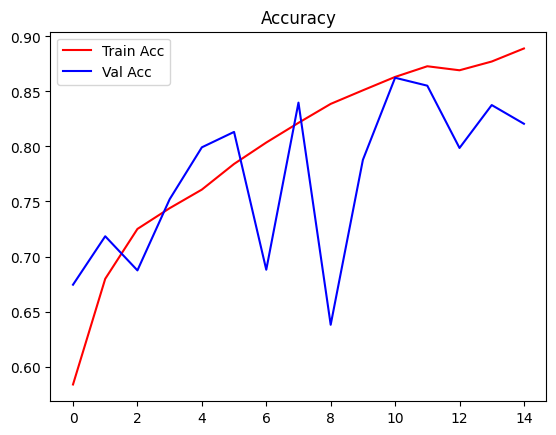

In [ ]:
plt.plot(history.history['accuracy'], label='Train Acc', color='red')
plt.plot(history.history['val_accuracy'], label='Val Acc', color='blue')
plt.legend()
plt.title("Accuracy")
plt.show()

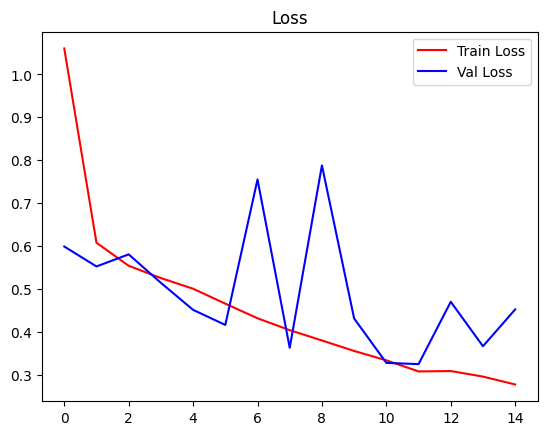

In [ ]:
plt.plot(history.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'], label='Val Loss', color='blue')
plt.legend()
plt.title("Loss")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 

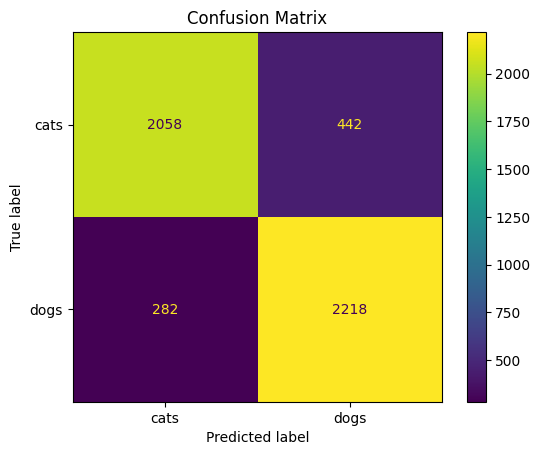

In [ ]:
y_true = []
y_pred = []

for images, labels in validation_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype("int32").flatten())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Prediction function for custom images
def predict_image(image_path):

    img = cv2.imread(image_path)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Prediction for: {image_path}")
    plt.axis('off')
    plt.show()


    img_resized = cv2.resize(img, (256, 256))
    img_input = img_resized.reshape((1, 256, 256, 3)).astype('float32') / 255.0

    pred = model.predict(img_input)[0][0]
    print("Prediction Score:", pred)
    if pred < 0.5:
        print("MY MODEL SAYS IT'S A CAT!")
    else:
        print("MY MODEL SAYS IT'S A DOG!")

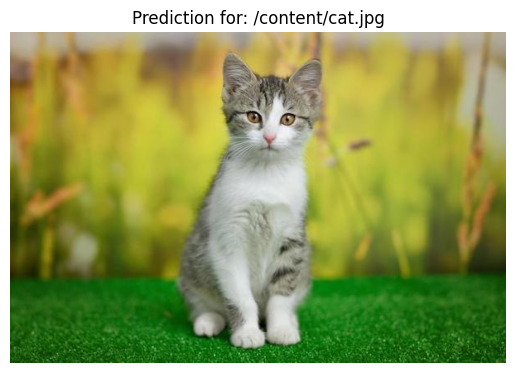

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction Score: 0.15063243
MY MODEL SAYS IT'S A CAT!


In [ ]:
predict_image('/content/cat.jpg')

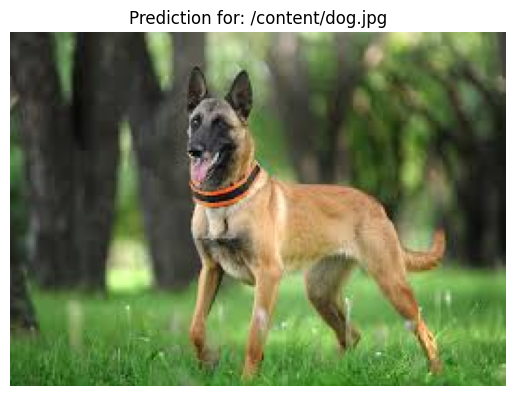

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction Score: 0.5670481
MY MODEL SAYS IT'S A DOG!


In [ ]:
predict_image('/content/dog.jpg')

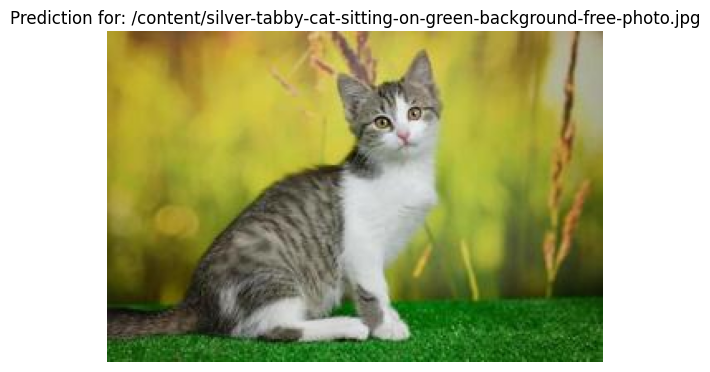

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction Score: 0.04730651
MY MODEL SAYS IT'S A CAT!


In [ ]:
predict_image('/content/silver-tabby-cat-sitting-on-green-background-free-photo.jpg')

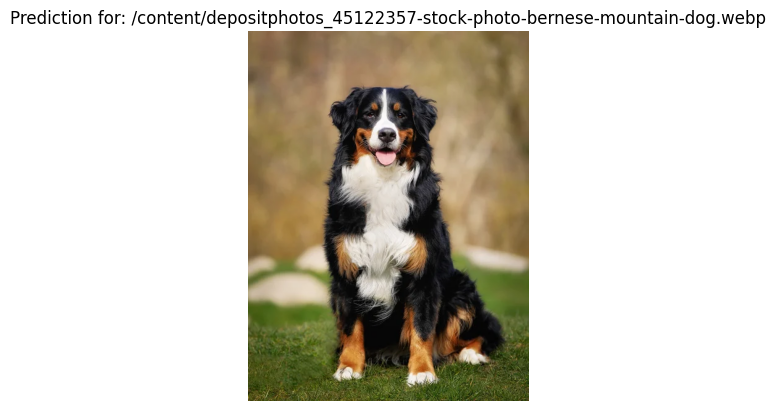

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction Score: 0.5614565
MY MODEL SAYS IT'S A DOG!


In [ ]:
predict_image('/content/depositphotos_45122357-stock-photo-bernese-mountain-dog.webp')

We can integrate Gradio to build an interactive web interface for this CNN model.

In [ ]:
import gradio as gr

In [ ]:
def predict_gradio(image):
    # Resize image to 256x256 and normalize
    image = cv2.resize(image, (256, 256))
    image = image.astype('float32') / 255.0
    image = image.reshape(1, 256, 256, 3)

    # Predict
    pred = model.predict(image)[0][0]

    # Output label and confidence
    label = "DOG 🐶" if pred >= 0.5 else "CAT 🐱"
    confidence = f"Confidence: {pred:.4f}" if pred >= 0.5 else f"Confidence: {1 - pred:.4f}"

    return f"{label}\n{confidence}"

In [ ]:
interface = gr.Interface(
    fn=predict_gradio,
    inputs=gr.Image(type="numpy", label="Upload an image"),
    outputs="text",
    title="Cat vs Dog Classifier 🐾",
    description="Upload an image of a cat or dog and see what the model predicts!"
)

# Launch it
interface.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ce9f6fd8be52a2bf36.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
